In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from scipy.stats import chi2_contingency

In [3]:
# Load the dataset
file_path = r"C:\Users\nprim\OneDrive\Desktop\PE\merged_results_v2.xlsx"
data = pd.read_excel(file_path)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

selected_columns = ['max_cath_size (F)', '72_hr_mortality (0/1)  0 = Still Living']
data_selected = data[selected_columns]
data_selected = data_selected.dropna()

# Convert columns to appropriate data types and handle UndefinedMetricWarning
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

data_selected['max_cath_size (F)'] = data_selected['max_cath_size (F)'].astype(float)
data_selected['72_hr_mortality (0/1)  0 = Still Living'] = data_selected['72_hr_mortality (0/1)  0 = Still Living'].astype(int)
data_selected['max_cath_size (F)'] = data_selected['max_cath_size (F)'].astype(float)
data_selected['72_hr_mortality (0/1)  0 = Still Living'] = data_selected['72_hr_mortality (0/1)  0 = Still Living'].astype(int)

# Separate features (X) and target (y)
X = data_selected[['max_cath_size (F)']]
y = data_selected['72_hr_mortality (0/1)  0 = Still Living']

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict the target variable
y_pred = log_reg.predict(X)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Calculate the Pearson correlation coefficient between max_cath_size (F) and 72_hr_mortality (0/1) 0 = Still Living
pearson_corr = data_selected['max_cath_size (F)'].corr(data_selected['72_hr_mortality (0/1)  0 = Still Living'])
print(f"Pearson correlation coefficient: {pearson_corr:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        62
           1       0.00      0.00      0.00         5

    accuracy                           0.93        67
   macro avg       0.46      0.50      0.48        67
weighted avg       0.86      0.93      0.89        67

Confusion Matrix:
[[62  0]
 [ 5  0]]
Pearson correlation coefficient: -0.0702


In [34]:
selected_columns = ['max_cath_size (F)', 'mean Pre-PA pressure (mmHg)', 'Post-PA pressure (mmHg)']
data_selected = data[selected_columns]

# Drop rows with any missing values
data_selected = data_selected.dropna()
print("Length of data_selected (number of data points for which we have pre/post PAP and max_cath_size):", len(data_selected))
# Calculate pressure difference
data_selected['pressure_difference'] = data_selected['mean Pre-PA pressure (mmHg)'] - data_selected['Post-PA pressure (mmHg)']

# Compute the correlation
correlation = data_selected['max_cath_size (F)'].astype(float).corr(data_selected['pressure_difference'].astype(float))

# Calculate the proportion of each max_cath_size
max_cath_size_proportion = data_selected['max_cath_size (F)'].value_counts(normalize=True)
print("Proportion of each max_cath_size:")
print(max_cath_size_proportion)

print(f"Correlation between max_cath_size and pressure_difference: {correlation:.4f}")


Length of data_selected (number of data points for which we have pre/post PAP and max_cath_size): 55
Proportion of each max_cath_size:
max_cath_size (F)
24.0    0.709091
16.0    0.127273
20.0    0.054545
8.0     0.018182
22.0    0.018182
18.0    0.018182
26.0    0.018182
12.0    0.018182
14.0    0.018182
Name: proportion, dtype: float64
Correlation between max_cath_size and pressure_difference: 0.1488


In [35]:
selected_columns = ['age', 'sex (F=0/M=1)', 'rvlv_ratio']
data_selected = data[selected_columns]

In [36]:
data_selected

,age,sex (F=0/M=1),rvlv_ratio
0,NaN,NaN,NaN
1,57.0,0.0,1.644326
2,39.0,0.0,NaN
3,63.0,1.0,1.354271
4,67.0,1.0,NaN
...,...,...,...
183,NaN,NaN,NaN
184,NaN,NaN,NaN
185,64.0,0.0,1.969127
186,73.0,1.0,NaN


In [37]:
# Drop rows with any empty cells in either X or y
data_selected = data[selected_columns + ['mean Pre-PA pressure (mmHg)']].dropna()

# Separate features (X) and target (y) after dropping rows with NaNs
X = data_selected[selected_columns]
y = data_selected['mean Pre-PA pressure (mmHg)']

In [38]:
len(y)

61

In [39]:
# Split into training and held-out test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the feature values (fit on training data, apply to both train and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the LinearRegression model
linear_model = LinearRegression()

# Fit the model on the training set
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the held-out test set
y_test_pred = linear_model.predict(X_test_scaled)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print metrics for the test set
print(f"\nHeld-Out Test Set Metrics:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")

# Optional: Print model coefficients
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]
coefficients = linear_model.coef_
intercept = linear_model.intercept_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print("\nModel Coefficients:")
print(coef_df)
print(f"Intercept: {intercept:.4f}")



Held-Out Test Set Metrics:
Mean Squared Error (MSE): 39.4701
Mean Absolute Error (MAE): 4.8622

Model Coefficients:
         Feature  Coefficient
0            age    -0.870853
1  sex (F=0/M=1)    -0.796289
2     rvlv_ratio     2.266886
Intercept: 28.0312


C:\Users\nprim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


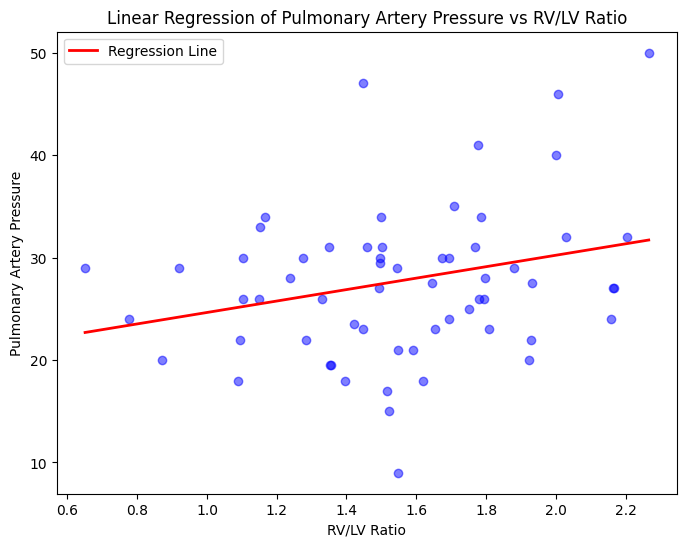

In [40]:
X_single = X[['rvlv_ratio']]  # Predictor of interest
y = y  # Target variable

# Split into training and test sets
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y, test_size=0.2, random_state=42)

# Fit the simple linear regression model
linear_model_single = LinearRegression()
linear_model_single.fit(X_train_single, y_train_single)

# Generate predictions for plotting the regression line
X_plot = np.linspace(X_single.values.min(), X_single.values.max(), 100).reshape(-1, 1)
y_plot = linear_model_single.predict(X_plot)

# Plot the scatter plot and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_single, y, color='blue', alpha=0.5)
plt.plot(X_plot, y_plot, color='red', linewidth=2, label='Regression Line')
plt.xlabel('RV/LV Ratio')
plt.ylabel('Pulmonary Artery Pressure')
plt.title('Linear Regression of Pulmonary Artery Pressure vs RV/LV Ratio')
plt.legend()
plt.show()


In [41]:
# Split into training and held-out test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the feature values (fit on training data, apply to both train and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 0.5, 0.1]
}

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Use KFold cross-validation for regression tasks
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use GridSearchCV for hyperparameter tuning on the training set
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the model using GridSearchCV on the training set
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score from GridSearchCV
best_mse = -grid_search.best_score_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Mean Squared Error on Training Set: {best_mse:.4f}")

# Train the final model with best parameters on the entire training set
best_xgb_model = XGBRegressor(**grid_search.best_params_, random_state=42)
best_xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the held-out test set
y_test_pred = best_xgb_model.predict(X_test_scaled)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print metrics for the test set
print(f"\nHeld-Out Test Set Metrics:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 1}
Best Mean Squared Error on Training Set: 55.3860

Held-Out Test Set Metrics:
Mean Squared Error (MSE): 41.7969
Mean Absolute Error (MAE): 5.3172


In [42]:
# Split into training and held-out test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the feature values (fit on training data, apply to both train and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjusted hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 500],
    'early_stopping': [True],
}

mlp_model = MLPRegressor(random_state=42, max_iter=1000)

# Re-run GridSearchCV with the adjusted parameters
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score from GridSearchCV
best_mse = -grid_search.best_score_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Mean Squared Error on Training Set: {best_mse:.4f}")

# Train the final model with best parameters on the entire training set
best_mlp_model = MLPRegressor(**grid_search.best_params_, random_state=42)
best_mlp_model.fit(X_train_scaled, y_train)

# Make predictions on the held-out test set
y_test_pred = best_mlp_model.predict(X_test_scaled)

# Calculate metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Print metrics for the test set
print(f"\nHeld-Out Test Set Metrics:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 200, 'solver': 'adam'}
Best Mean Squared Error on Training Set: 59.0667

Held-Out Test Set Metrics:
Mean Squared Error (MSE): 34.7478
Mean Absolute Error (MAE): 5.2402


In [43]:
correlation = X["rvlv_ratio"].corr(y)
print(f"Correlation between RV/LV Ratio and Pre-PA Pressure: {correlation:.4f}")

Correlation between RV/LV Ratio and Pre-PA Pressure: 0.2636


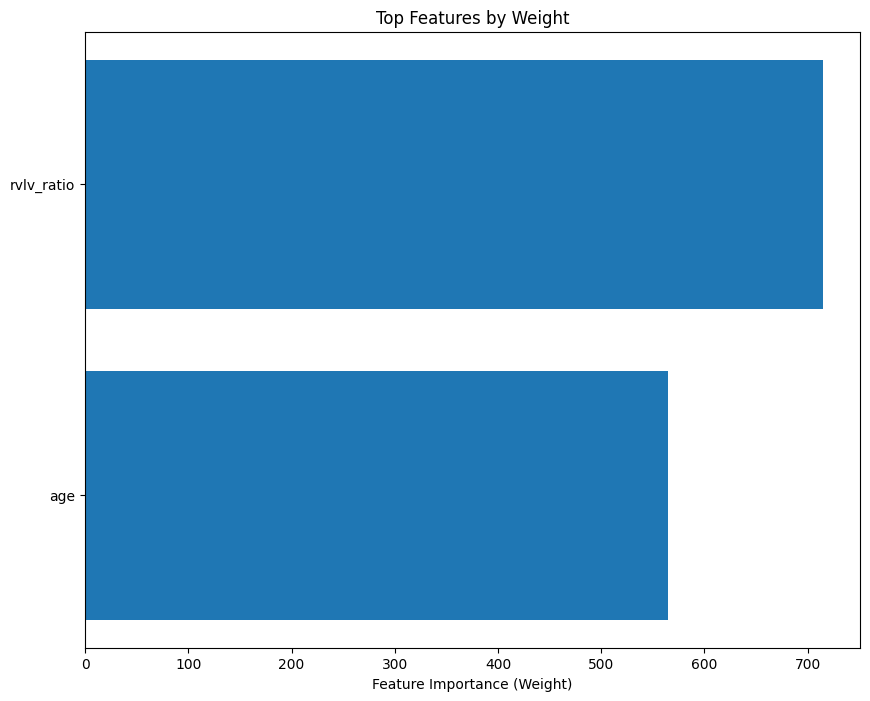

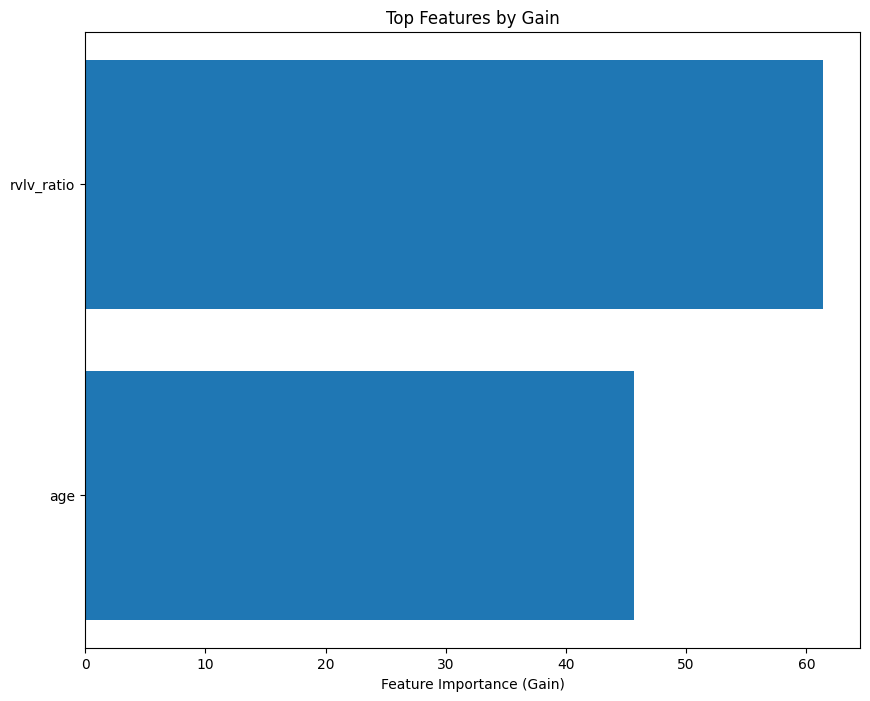

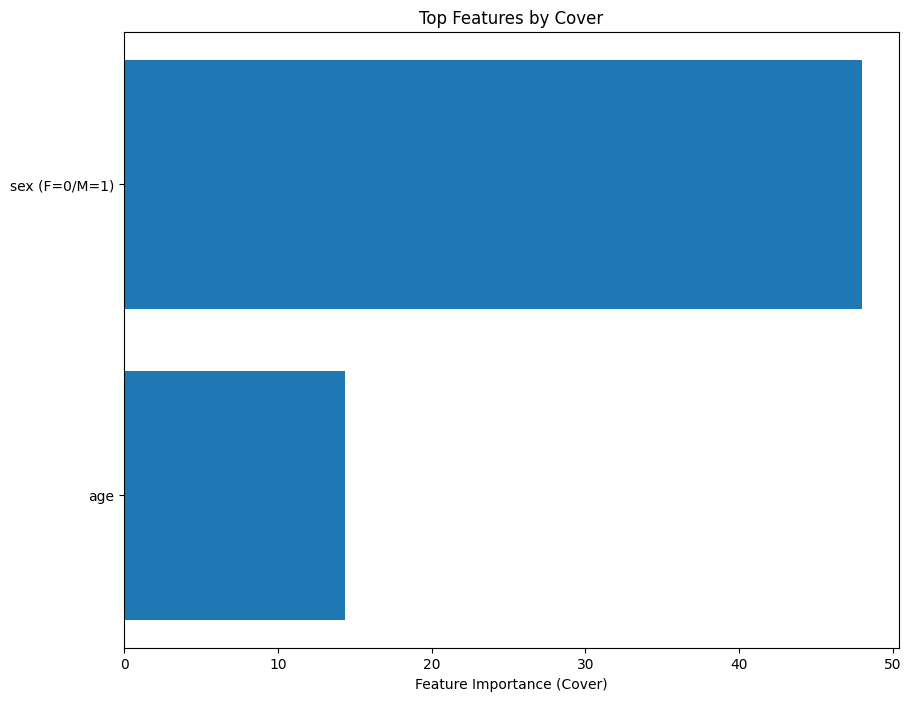

In [45]:
# Extract the feature importances for each type (weight, gain, cover)
importance_types = ['weight', 'gain', 'cover']
feature_names = np.array(X.columns)

for importance_type in importance_types:
    # Get the importance values
    importances = best_xgb_model.get_booster().get_score(importance_type=importance_type)

    # Convert to a sorted list (sorted by importance)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    
    # Extract top features
    top_features = sorted_importances[:3]
    feature_labels = [feature_names[int(f[1:].replace('f', ''))] for f, v in top_features]
    feature_values = [v for f, v in top_features]
    
    # Plot the top features by the current importance type
    plt.figure(figsize=(10, 8))
    plt.barh(feature_labels, feature_values)
    plt.xlabel(f"Feature Importance ({importance_type.capitalize()})")
    plt.title(f"Top Features by {importance_type.capitalize()}")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()
